In [65]:
import os
import sys
from pathlib import Path

import librosa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
from src.utils.eeg_spectrogram_creator import EEGSpectrogramGenerator

plt.rcParams['font.size'] = 12          # Base font size
plt.rcParams['axes.titlesize'] = 18     # Axes title
plt.rcParams['axes.labelsize'] = 16     # X and Y labels
plt.rcParams['xtick.labelsize'] = 14    # X tick labels
plt.rcParams['ytick.labelsize'] = 14    # Y tick labels
plt.rcParams['legend.fontsize'] = 14    # Legend
plt.rcParams['figure.titlesize'] = 30   # Figure title (suptitle)

In [66]:
CHAIN = "LL"

SPECTROGRAM_1_INDEX = 550
SPECTROGRAM_2_INDEX = 1000

TRAIN_CSV = Path(os.getcwd()).parent.parent / "data" / "train.csv"
KAGGLE_SPECTROGRAM_DIR = Path(os.getcwd()).parent.parent / "data" / "train_spectrograms"

In [67]:
train_df = pd.read_csv(TRAIN_CSV)

row_1 = train_df.iloc[SPECTROGRAM_1_INDEX]
row_2 = train_df.iloc[SPECTROGRAM_2_INDEX]

spectrogram_1_id = row_1["spectrogram_id"]
spectrogram_2_id = row_2["spectrogram_id"]

spectrogram_1_path = KAGGLE_SPECTROGRAM_DIR / f"{spectrogram_1_id}.parquet"
spectrogram_2_path = KAGGLE_SPECTROGRAM_DIR / f"{spectrogram_2_id}.parquet"

spectrogram_1_offset = row_1["spectrogram_label_offset_seconds"]
spectrogram_2_offset = row_2["spectrogram_label_offset_seconds"]

In [68]:
def clean_kaggle_spectrogram(data):
    data = librosa.amplitude_to_db(data, ref=np.max) 
    data = EEGSpectrogramGenerator([])._normalize_spectrogram(data)
    data = np.pad(data, ((14, 14), (0, 0)), mode='constant', constant_values=0)
    data = data[:, (data.shape[1] - 256) // 2 : (data.shape[1] + 256) // 2]

    return data

spectrogram_1_content = pd.read_parquet(spectrogram_1_path).drop(columns=["time"])
spectrogram_2_content = pd.read_parquet(spectrogram_2_path).drop(columns=["time"])

spectrogram_1_content = spectrogram_1_content.iloc[int(spectrogram_1_offset // 2) : int(spectrogram_1_offset // 2 + 600 / 2)] # select 600 seconds of data
spectrogram_2_content = spectrogram_2_content.iloc[int(spectrogram_2_offset // 2) : int(spectrogram_2_offset // 2 + 600 / 2)] # select 600 seconds of data

spectrogram_1_content = spectrogram_1_content.filter(like=CHAIN).to_numpy().T
spectrogram_2_content = spectrogram_2_content.filter(like=CHAIN).to_numpy().T

spectrogram_1_content = clean_kaggle_spectrogram(spectrogram_1_content)
spectrogram_2_content = clean_kaggle_spectrogram(spectrogram_2_content)

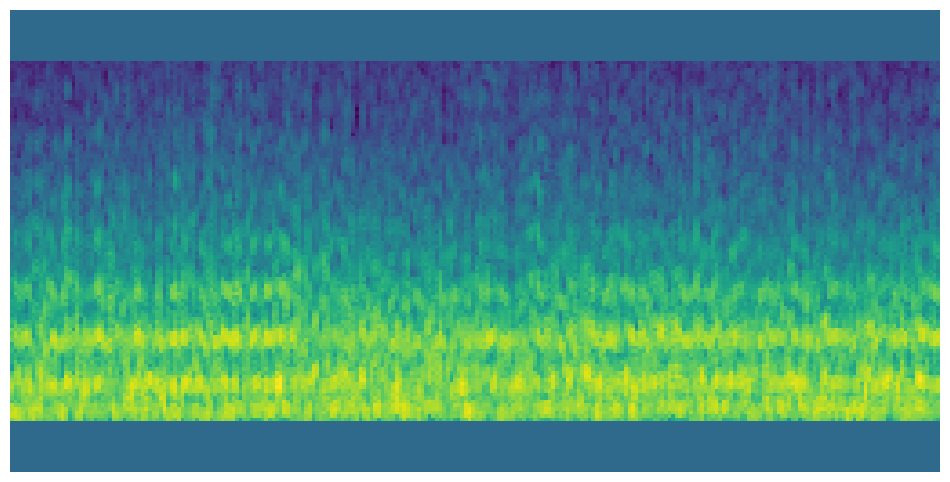

In [69]:
fig, ax = plt.subplots(figsize=(256 // 20, 128 // 20))
ax.imshow(spectrogram_1_content, aspect='auto', origin='lower', cmap='viridis')
ax.set_axis_off()

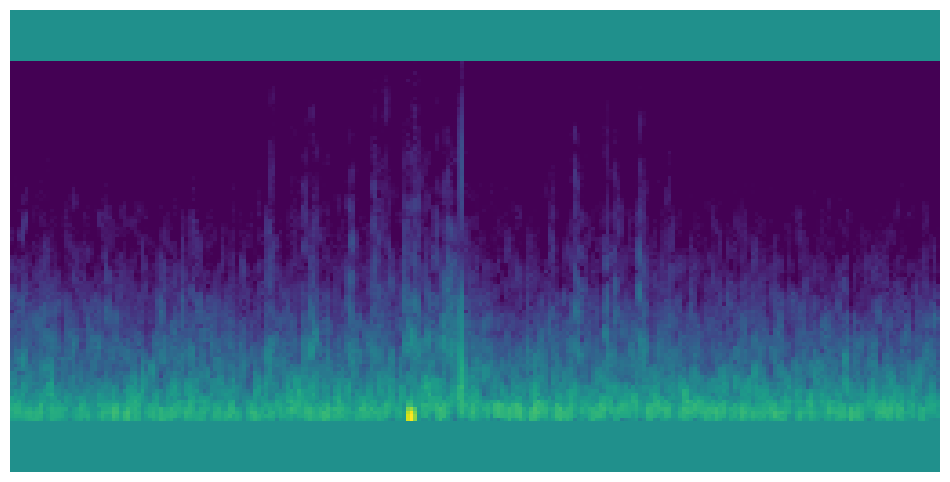

In [70]:
fig, ax = plt.subplots(figsize=(256 // 20, 128 // 20))
ax.imshow(spectrogram_2_content, aspect='auto', origin='lower', cmap='viridis')
ax.set_axis_off()

In [71]:
def mixup_spectrograms(spec1, spec2, lam):
    mixed_spec = lam * spec1 + (1 - lam) * spec2
    return mixed_spec
  
mixed_spectrogram = mixup_spectrograms(spectrogram_1_content, spectrogram_2_content, 0.5)

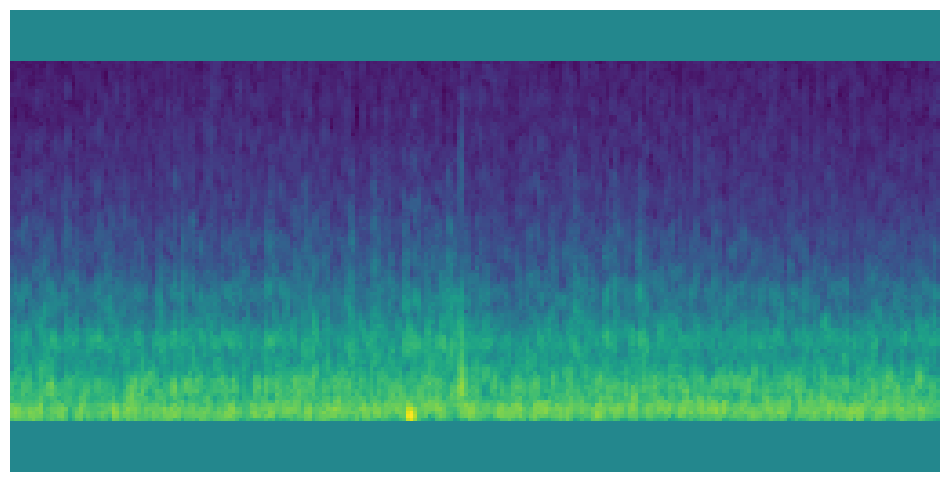

In [72]:
fig, ax = plt.subplots(figsize=(256 // 20, 128 // 20))
ax.imshow(mixed_spectrogram, aspect='auto', origin='lower', cmap='viridis')
ax.set_axis_off()